<a href="https://colab.research.google.com/github/Krishnan-Raghavan/Packt/blob/main/StableDiffusionChapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#Import Libraries/Packages required to run the code for this chapter

!pip install diffusers
!pip install PEFT

In [11]:
import torch
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.float16
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

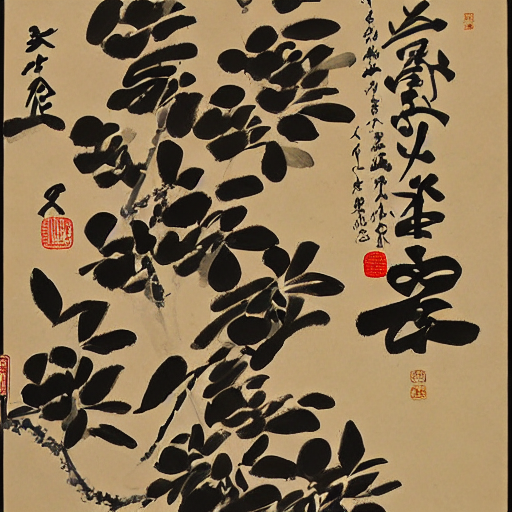

In [12]:
prompt = """
shukezouma, shuimobysim ,a branch of flower, traditional chinese ink painting
"""
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

In [13]:
# load LoRA to the pipeline
pipeline.load_lora_weights(
    "andrewzhu/MoXinV1"
    , weight_name   = "MoXinV1.safetensors"
    , adapter_name  = "MoXinV1"
)

  0%|          | 0/50 [00:00<?, ?it/s]

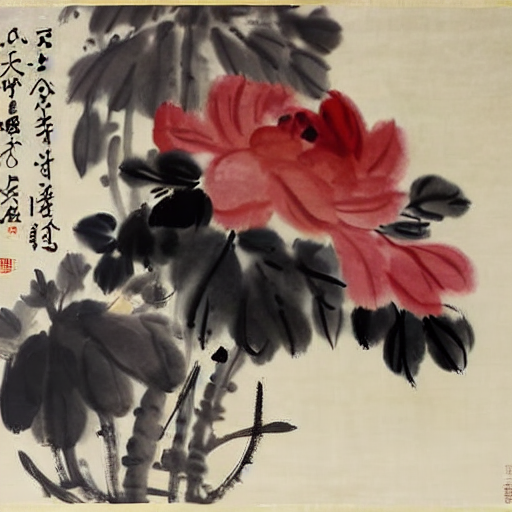

In [14]:
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

  0%|          | 0/50 [00:00<?, ?it/s]

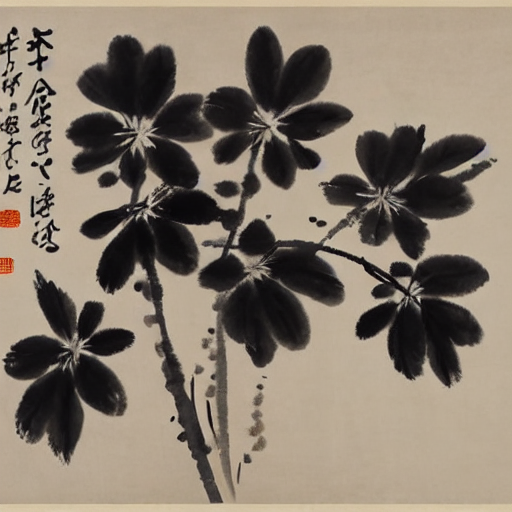

In [15]:
pipeline.set_adapters(
    ["MoXinV1"]
    , adapter_weights=[0.5]
)
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

In [16]:
# load another LoRA to the pipeline
pipeline.load_lora_weights(
    "andrewzhu/civitai-light-shadow-lora"
    , weight_name   = "light_and_shadow.safetensors"
    , adapter_name  = "light_and_shadow"
)

  0%|          | 0/50 [00:00<?, ?it/s]

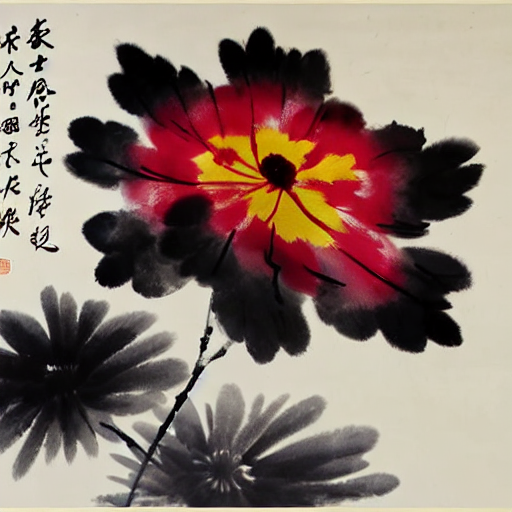

In [17]:
pipeline.set_adapters(
    ["MoXinV1", "light_and_shadow"]
    , adapter_weights=[0.5,1.0]
)
prompt = """
shukezouma, shuimobysim ,a branch of flower, traditional chinese ink painting,STRRY LIGHT,COLORFUL
"""
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

In [18]:
pipeline.disable_lora()

In [30]:
# load lora file
from safetensors.torch import load_file
lora_path = "/content/MoXinV1.safetensors"
state_dict = load_file(lora_path)
for key in state_dict:
    print(key)

SafetensorError: Error while deserializing header: MetadataIncompleteBuffer

In [34]:
# find the layer name
LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'
for key in state_dict:
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipeline.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipeline.unet

NameError: name 'state_dict' is not defined

In [35]:
unet = pipeline.unet
modules = unet.named_modules()
for child_name, child_module in modules:
    print("child_module:",child_module)

Streaming output truncated to the last 5000 lines.
  (lora_dropout): ModuleDict(
    (MoXinV1): Identity()
    (light_and_shadow): Identity()
  )
  (lora_A): ModuleDict(
    (MoXinV1): Linear(in_features=768, out_features=128, bias=False)
    (light_and_shadow): Linear(in_features=768, out_features=128, bias=False)
  )
  (lora_B): ModuleDict(
    (MoXinV1): Linear(in_features=128, out_features=320, bias=False)
    (light_and_shadow): Linear(in_features=128, out_features=320, bias=False)
  )
  (lora_embedding_A): ParameterDict()
  (lora_embedding_B): ParameterDict()
)
child_module: Linear(in_features=768, out_features=320, bias=False)
child_module: ModuleDict(
  (MoXinV1): Identity()
  (light_and_shadow): Identity()
)
child_module: Identity()
child_module: Identity()
child_module: ModuleDict(
  (MoXinV1): Linear(in_features=768, out_features=128, bias=False)
  (light_and_shadow): Linear(in_features=768, out_features=128, bias=False)
)
child_module: Linear(in_features=768, out_features=1

In [37]:
for key in state_dict:
    # find the LoRA layer name (the same code showed above)
    for key in state_dict:
      if 'text' in key:
        layer_infos = key.split('.')[0].split("lora_unet_")[-1].split('_')
        curr_layer = pipeline.text_encoder
      else:
        layer_infos = key.split('.')[0].split("lora_te_")[-1].split('_')
        curr_layer = pipeline.unet

    # loop through the layers to find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            # no exception means the layer is found
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            # all names are pop out, break out from the loop
            elif len(layer_infos) == 0:
                break
        except Exception:
            # no such layer exist, pop next name and try again
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                # temp_name is empty
                temp_name = layer_infos.pop(0)

NameError: name 'state_dict' is not defined

In [38]:
# ensure the sequence of lora_up(A) then lora_down(B)
pair_keys = []
if 'lora_down' in key:
    pair_keys.append(key.replace('lora_down', 'lora_up'))
    pair_keys.append(key)
else:
    pair_keys.append(key)
    pair_keys.append(key.replace('lora_up', 'lora_down'))

NameError: name 'key' is not defined

In [39]:
alpha = 0.5
# update weight
if len(state_dict[pair_keys[0]].shape) == 4:
    # squeeze(3) and squeeze(2) remove dimensions of size 1 from the tensor to make the tensor more compact
    weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
    weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
    curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
else:
    weight_up = state_dict[pair_keys[0]].to(torch.float32)
    weight_down = state_dict[pair_keys[1]].to(torch.float32)
    curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

NameError: name 'state_dict' is not defined

In [40]:
def load_lora(
    pipeline
    , lora_path
    , lora_weight = 0.5
    , device = 'cpu'
):
    state_dict = load_file(lora_path, device=device)
    LORA_PREFIX_UNET = 'lora_unet'
    LORA_PREFIX_TEXT_ENCODER = 'lora_te'

    alpha = lora_weight
    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # as we have set the alpha beforehand, so just skip
        if '.alpha' in key or key in visited:
            continue

        if 'text' in key:
            layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
            curr_layer = pipeline.unet

        # find the target layer
        # loop through the layers to find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                # no exception means the layer is found
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                # layer found but length is 0,
                # break the loop and curr_layer keep point to the current layer
                elif len(layer_infos) == 0:
                    break
            except Exception:
                # no such layer exist, pop next name and try again
                if len(temp_name) > 0:
                    temp_name += '_'+layer_infos.pop(0)
                else:
                    # temp_name is empty
                    temp_name = layer_infos.pop(0)

        # org_forward(x) + lora_up(lora_down(x)) * multiplier
        # ensure the sequence of lora_up(A) then lora_down(B)
        pair_keys = []
        if 'lora_down' in key:
            pair_keys.append(key.replace('lora_down', 'lora_up'))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace('lora_up', 'lora_down'))

        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            # squeeze(3) and squeeze(2) remove dimensions of size 1 from the tensor to make the tensor more compact
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

        # update visited list, ensure no duplicated weight is processed.
        for item in pair_keys:
            visited.append(item)

In [41]:
pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
    , torch_dtype = torch.bfloat16
).to("cuda:0")

lora_path = r"MoXinV1.safetensors"
load_lora(
    pipeline = pipeline
    , lora_path = lora_path
    , lora_weight = 0.5
    , device = "cuda:0"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


SafetensorError: Error while deserializing header: MetadataIncompleteBuffer

In [42]:
prompt = """
shukezouma, shuimobysim ,a branch of flower, traditional chinese ink painting
"""
image = pipeline(
    prompt = prompt
    , generator = torch.Generator("cuda:0").manual_seed(1)
).images[0]
display(image)

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: cutlassF: no kernel found to launch!